# Resume Extraction Project

This project takes open data of resumes written by many candidates and extracts informations.

In [7]:


with open(r'data/new_resumes.json', encoding='utf8') as f:
    
    data_file= f.read()
 



## Approach

The approach here is to take as target the highlighted information under the "text" part for each instance. 


Below is the data cleaning process to extract this information using the regular expressions library.


In [8]:
import re
import pandas as pd

new_data = data_file.split('}]}]}')
informations_candidates = []

for data in new_data:
    #information = re.findall(r'"text":([^\"])"}',data)
    data = data.replace(r'\n', ' ')
    data = data.replace('-', ' ')
    data = data.replace(r'/', ' ')
    information = re.findall(r'"text":"([^"]+)"}',data)
    # A set is taken to avoid repetition
    to_append = list(set(information))
    if len(to_append)==0:
        informations_candidates.append(pd.NA)
    else:        
        informations_candidates.append(to_append)



In [10]:


df = pd.DataFrame({'Text': new_data, 'Information extracted': informations_candidates})


In [11]:
df.iloc[1,1]

[' Osmania University ',
 '6 Yrs',
 'Functional Testing, Blue Prism, Qtp ',
 'MCA',
 'Manual and Automation testing.',
 'Hyderabad',
 'QA Analyst',
 'Test Analyst',
 'B.Sc. in Computer Science']

# EDA 

We are performing exploratory data analysis (EDA) on the data. Below is some statistical analysis of the distribution of word lenghts and character lenghts.



In [13]:
print(f"There are initially {sum(df.iloc[:,1].isna())} NA in the dataset.")

df = df.dropna()

print(f"There are now {sum(df.iloc[:,1].isna())} NA in the dataset after dropping them.")

There are initially 0 NA in the dataset.
There are now 0 NA in the dataset after dropping them.


Text(13.819444444444445, 0.5, 'number of samples with this average character number')

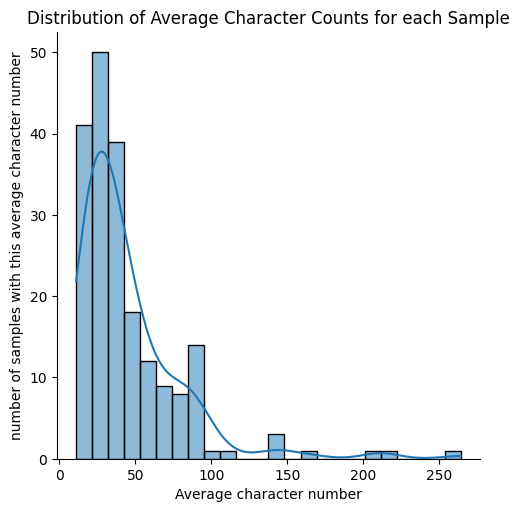

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

char_count = df.iloc[:,1].map(lambda x: sum([len(i) for i in x])/len(x))

sns.displot(char_count, kde = True)
plt.title("Distribution of Average Character Counts for each Sample")

plt.xlabel('Average character number')
plt.ylabel('number of samples with this average character number')

Text(13.819444444444445, 0.5, 'number of samples with this average number of words')

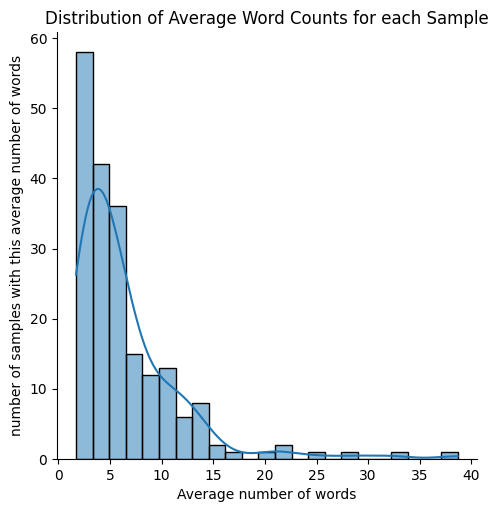

In [15]:
word_count = df.iloc[:,1].map(lambda x: sum([len(i.split()) for i in x])/len(x))

sns.displot(word_count, kde = True)

plt.title("Distribution of Average Word Counts for each Sample")

plt.xlabel('Average number of words')
plt.ylabel('number of samples with this average number of words')


#### Semantic Similarity 

We are now visualizing the proximity of semantically similar words.

In [16]:

from sentence_transformers import  SentenceTransformer

c:\Users\hp\Desktop\Data_Glacier\internship_projects\Final_project\Resume-Extraction\venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001B8393BF520>>
Traceback (most recent call last):
  File "c:\Users\hp\Desktop\Data_Glacier\internship_projects\Final_project\Resume-Extraction\venv\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


c:\Users\hp\Desktop\Data_Glacier\internship_projects\Final_project\Resume-Extraction\venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Text(0, 0.5, 'Value of the 3rd dimension in the vector space')

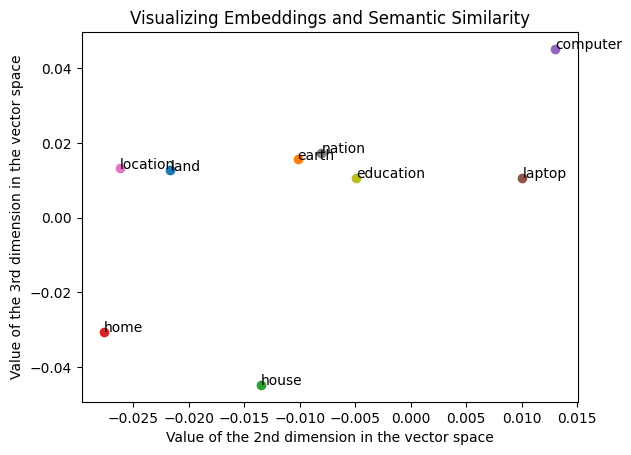

In [17]:
import matplotlib.pyplot as plt
import numpy as np

model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

list_of_words = ["land", "earth", "house", "home", "computer", "laptop", "location", "nation", 'education']

vectors = [model.encode(i) for i in list_of_words]

vectors = np.array(vectors)

for v in range(len(vectors)):
   
   plt.scatter(vectors[v][2], vectors[v][3])
   plt.annotate(list_of_words[v], xy= (vectors[v][2], vectors[v][3]))

plt.title("Visualizing Embeddings and Semantic Similarity")

plt.xlabel("Value of the 2nd dimension in the vector space")
plt.ylabel("Value of the 3rd dimension in the vector space")

     




Text(0.5, 1.0, 'Embedding Similarity Heatmap')

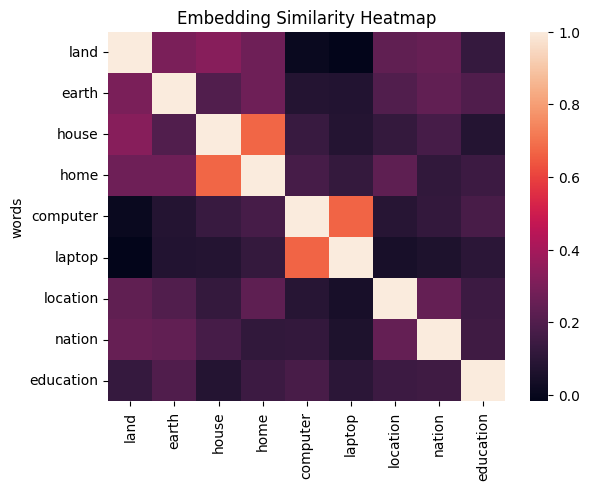

In [18]:
import seaborn as sns
import pandas as pd

d = pd.DataFrame(np.array(vectors)@np.array(vectors).T, columns= list_of_words)
d['words'] = list_of_words
d = d.set_index('words')
sns.heatmap(d)
plt.title('Embedding Similarity Heatmap')

## Modeling technique

Using a triplet loss is solution. This involves training a model with data points considered "positive", others considered "negative" and an anchor (the actual sample). The goal is to train the model to get answers for a given anchor close to its label (positive or negative). 

Another approach, which is the one adopted here, is to work on maximizing the similarity score (cosine similarity score) between the embeddings of the relevant parts to extract in the sample and the corresponding words we took as positive. These parts are the relevant ones after splitting the text according to new lines, as it follows a logic pattern here. The words more similar than a threshold value in similarity matrix are then extracted. We use the sentence transformers library which has ready embeddings, although they can be fine tuned for our use case.

c:\Users\hp\Desktop\Data_Glacier\internship_projects\Final_project\Resume-Extraction\venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Text(0, 0.5, 'Value of the 3rd dimension in the vector space')

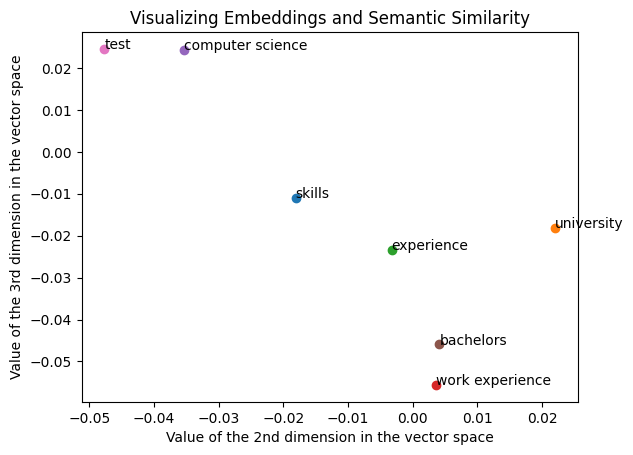

In [19]:
import matplotlib.pyplot as plt
import numpy as np

model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

list_of_words = ["skills", "university", "experience", "work experience", "computer science", "bachelors", "test"]

vectors = [model.encode(i) for i in list_of_words]

vectors = np.array(vectors)

for v in range(len(vectors)):
   
   plt.scatter(vectors[v][2], vectors[v][3])
   plt.annotate(list_of_words[v], xy= (vectors[v][2], vectors[v][3]))

plt.title("Visualizing Embeddings and Semantic Similarity")

plt.xlabel("Value of the 2nd dimension in the vector space")
plt.ylabel("Value of the 3rd dimension in the vector space")

     




In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

a = model.encode("istanbul technical university")
b = model.encode("university")

print(f"""The output of the similarity function of the model: {model.similarity(a,b)[0][0]}; 
is the same as the dot product (inner product) of the embedding vectors: {a@b}""")

c:\Users\hp\Desktop\Data_Glacier\internship_projects\Final_project\Resume-Extraction\venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


The output of the similarity function of the model: 0.4779433012008667; 
is the same as the dot product (inner product) of the embedding vectors: 0.4779433012008667


## Training Possibility

Another possibility is to fine-tune the model (train it on our data), to increase accuracy on our data. Below are small text pairs which we want to have similar embedding outputs that is used with the trainer class of sentence transformers.

As for the technical aspect, training an AI model consists in general of modifying the parameters (weights and biases) so as to minimize some kind of cost function for the model.

In [7]:
import numpy as np

a= df.iloc[0,1] + df.iloc[1,1] 
b = ["consultant", "year", "experience", "consultant", "consultant", "website link", "cloud", "engineer", "location", "programming languages", "university degree", "university", "university", "test", "years", "analyst", "analyst", "location", "university degree", "test", "skills"]


train_data = pd.DataFrame({'Texts1' : a, "Texts2": b,"Labels" : np.ones(len(a))})
train_data.head()

,Texts1,Texts2,Labels
0,Bengaluru,consultant,1.0
1,Adithya Institute of Technology,year,1.0
2,Senior Software Engineer,experience,1.0
3,Associate Consultant,consultant,1.0
4,indeed.com r Govardhana K b2de315d95905b68,consultant,1.0


In [8]:
l1 = ["Programming (3 years)", "Istanbul","Masters degree in Computer Science"]
l2 = ["Skills",  "location", "university degree"]

val_data = pd.DataFrame({"Texts1": l1 , "Texts2": l2,"Labels": [1,1,1]})
val_data


,Texts1,Texts2,Labels
0,Programming (3 years),Skills,1
1,Istanbul,location,1
2,Masters degree in Computer Science,university degree,1


In [9]:
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from sentence_transformers.losses import CosineSimilarityLoss, CoSENTLoss
from datasets import Dataset
from torch import manual_seed

manual_seed(0)

#l = [[a[i],b[i]] for i in range(len(a))]

model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

loss = CoSENTLoss(model)

train = Dataset.from_dict({'sentence1' : a, 'sentence2': b,"score" : np.ones(len(a))})
val = Dataset.from_pandas(val_data)

args = SentenceTransformerTrainingArguments(
    output_dir = "models/trial",
    num_train_epochs = 2, 
    per_device_train_batch_size = 3,
    per_device_eval_batch_size = 2
)

trainer = SentenceTransformerTrainer(model= model, args=args, train_dataset=train, eval_dataset=val,loss=loss)

trainer.train()





c:\Users\hp\Desktop\Data_Glacier\internship_projects\Final_project\Resume-Extraction\venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 14/14 [00:33<00:00,  2.41s/it]

{'train_runtime': 33.6854, 'train_samples_per_second': 1.247, 'train_steps_per_second': 0.416, 'train_loss': 0.0, 'epoch': 2.0}


TrainOutput(global_step=14, training_loss=0.0, metrics={'train_runtime': 33.6854, 'train_samples_per_second': 1.247, 'train_steps_per_second': 0.416, 'total_flos': 0.0, 'train_loss': 0.0, 'epoch': 2.0})

## First Model testing

We test the first model described above.

In [44]:
from script import evaluate 

print(f'The extracted information for the first resume is: {list(evaluate(df.iloc[0,0]))}')


The extracted information for the first resume is: ['Total IT experience 5 Years 6 Months', 'Languages Core Java, Go Lang', 'Willing to relocate: Anywhere', 'WORK EXPERIENCE', 'Senior Consultant', 'Staff Consultant', 'Associate Consultant', 'EDUCATION', 'SKILLS', 'Technical Proficiency:', 'Languages: Core Java, Go Lang, Data Structures & Algorithms, ']


## Second Model Testing

We are testing the second model, a fine tuned distillbart-cnn-12-6 model from HuggingFace.

In [21]:
a = df.iloc[4,0]
a

'\n{"content": "Imgeeyaul Ansari\\njava developer\\n\\nPune, Maharashtra - Email me on Indeed: indeed.com/r/Imgeeyaul-Ansari/a7be1cc43a434ac4\\n\\nWilling to relocate to: Pune, Maharashtra\\n\\nWORK EXPERIENCE\\n\\nApplication Developer\\n\\n Software Services -  Pune, Maharashtra -\\n\\nAugust 2016 to Present\\n\\n• Wrote Services in java using data annotation which in turn were used for creating other files\\nusing code generation tool.\\n\\n• Jar of services with related utility files such as DTOs are deployed on the Host side.\\n\\n• Host side is hosted on Tomcat Server where proxy files are present.\\n\\n• Created jsff page for UI, and wrote action, helper, assembler, backing bean for UI side business\\nLogic made entries in collectionAppModule, PageDef.\\n\\n• Used ADF & MVC architecture for building application.\\n\\nUsed JUnit for Testing services,Algorithms.\\nAlso made test Suites For running multiple test case at one go.\\n\\nUsed Eclipse Debugger for Fixing Service Related 

In [22]:
from model2 import summarize

print(summarize(a))

  
{"content": "Imgeeyaul Ansari\njava developer\n\nPune, Maharashtra. He will relocate to Pune, Maharashtra and Software Services in java using data annotation which in turn were used for creating other files\nusing code generation tool. He is hosted on Tomcat Server where proxy files are present and Created jsff page for UI, and wrote action, helper, assembler, backing bean for UI.
